In [1]:
from __future__ import print_function
from Bio.PDB import *
import os
import numpy as np
import collections

from scipy.spatial import distance
from pygsp import graphs, features
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
amino_lookup = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N',
     'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W',
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}
amino_molecular_mass = {'A': 89.09404, 'R': 174.20274, 'N': 132.11904, 'D': 133.10384, 'C': 121.15404,
                        'Q': 146.14594, 'E': 147.13074, 'G': 75.06714, 'H': 155.15634, 'I': 131.17464,
                        'L': 131.17464, 'K': 146.18934, 'M': 149.20784, 'F': 165.19184, 'P': 115.13194,
                        'S': 105.09344, 'T': 119.12034, 'W': 204.22844, 'Y': 181.19124, 'V': 117.14784}
amino_hydrophobicity = {'A': 1.8, 'R': -4.5, 'N': -3.5, 'D': -3.5, 'C': 2.5,
                        'Q': -3.5, 'E': -3.5, 'G': -0.4, 'H': -3.2, 'I': 4.5,
                        'L': 3.8, 'K': -3.9, 'M': 1.9, 'F': 2.8, 'P': -1.6,
                        'S': -0.8, 'T': -0.7, 'W': -0.9, 'Y': -1.3, 'V': 4.2}


In [3]:
def crawl_pdb(path):
    '''This funciton reads pdb files and stores there distance matrix and sequence'''
    parser = PDBParser()
    pdb_files = sorted(os.listdir(path))
    pdbinfo_dict = dict()
    for pdb in pdb_files:
        info = dict()
        info[id] = pdb
        structure = parser.get_structure('pdb_file', path + '/' + pdb + '/' + pdb + '.pdb')
        coordinates = []
        labels = list()
        for model in structure:
            for chain in model:
                for residue in chain:
                    try:
                        coordinates.append(residue['CA'].get_coord())
                        labels.append(residue.get_resname())
                    except KeyError:
                        pass
                break  ## working on chain id A only
            break      ## Working on model id 0 only
        coords = np.asmatrix(coordinates)
        distance_matrix = distance.squareform(distance.pdist(coords))
        info['coords'] = coords
        info['distance_matrix'] = distance_matrix
        info['sequence'] = ''.join([amino_lookup[s] for s in labels])
        pdbinfo_dict[pdb] = info
    return pdbinfo_dict


def get_graph(distance_matrix, network_type, rig_cutoff=8, lin_cutoff=12):
    distance_matrix[distance_matrix >= rig_cutoff] = 0
    if network_type == 'rig-boolean':
        distance_matrix[distance_matrix > 0] = 1
    elif network_type == 'weighted-rig':
        for i in range(np.shape(distance_matrix)[0]):
            for j in range(np.shape(distance_matrix)[1]):
                if distance_matrix[i, j] > 0:
                    distance_matrix[i, j] = abs(j - i)
    elif network_type == 'weighted-lin':
        for i in range(np.shape(distance_matrix)[0]):
            for j in range(np.shape(distance_matrix)[1]):
                if distance_matrix[i, j] > 0:
                    if abs(i - j) >= lin_cutoff or abs(i - j) == 1:
                        distance_matrix[i, j] = abs(i - j)
                    else:
                        distance_matrix[i, j] = 0
    elif network_type == 'lin':
        for i in range(np.shape(distance_matrix)[0]):
            for j in range(np.shape(distance_matrix)[1]):
                if distance_matrix[i, j] > 0:
                    if abs(i - j) >= lin_cutoff or abs(i - j) == 1:
                        distance_matrix[i, j] = 1
                    else:
                        distance_matrix[i, j] = 0
    else:
        print('Invalid Choice! ' + network_type)
        return None
    G = graphs.Graph(distance_matrix, lap_type='normalized')
    G.compute_fourier_basis()
    return G


def get_signal(G, seq, signal):
    if signal == 'molecular_weight':
        s = np.asarray([amino_molecular_mass[aa] for aa in seq])
    elif signal == 'hydrophobicity':
        s = np.asarray([amino_hydrophobicity[aa] for aa in seq])
    elif signal == 'node_degree':
        s = G.d
    elif signal == 'node_weighted_degree':
        adj = G.W.todense()
        s = np.ravel(adj.sum(axis=0)) / 2
    elif signal == 'avg_adj_degree':
        s = features.compute_avg_adj_deg(G)
        s = np.ravel(s)
    elif signal == 'clustering_coeff':
        N = nx.from_scipy_sparse_matrix(G.W)
        s = nx.clustering(N)
        s = np.asarray(list(s.values()))
    elif signal == 'aaalpha_helix':
        s = eng.aaalpha_helixfasman(seq)
        s = np.array(s._data)
    elif signal == 'residue_count':
        residue_counts = collections.Counter(seq)
        s = np.asarray([residue_counts[s] for s in seq])
    else:
        print ('Invalid Choice! ' + signal)
    return s


def get_filtered_signal(G, signal, cutoff):
    signal_hat = G.gft(signal)
    signal_filtered_hat = np.zeros_like(signal_hat)
    signal_filtered_hat[G.e < G.lmax * cutoff] = signal_hat[G.e < G.lmax * cutoff]
    signal_filtered = G.igft(signal_filtered_hat)
    return signal_filtered

In [6]:
model = 'weighted-rig'
signal_name = 'hydrophobicity'
# lfc_cutoff = 0.14

In [7]:
prion_path = '../data/Prion/'
pdbinfo_dict = crawl_pdb(prion_path)

In [8]:
print (pdbinfo_dict.keys())

dict_keys(['5yj4', '5yj5', 'CYC8'])


In [9]:
s1 = pdbinfo_dict['5yj4']['sequence']
s2 = pdbinfo_dict['5yj5']['sequence']

assert len(s1) == len(s2)

In [10]:
for i in range(0, len(s1), 80):
    sec1 = s1[i:i+80]
    sec2 = s2[i:i+80]
    print (sec1)
    for i in range(len(sec1)):
        if sec1[i] == sec2[i]:
            print ('.', end='')
        else:
            print('|', end='')
            index = i
    print('')
    print (sec2)
    print ()
    
print ("Mutation caught at index = ", index)

MQGGGTHSQWNKPSKPKTNMKHMAGAAAAGAVVGGLGVYMLGSAMSRPIIHFGSDYEDRYYRENMHRYPNQVYYRPMDEY
.....................................|..........................................
MQGGGTHSQWNKPSKPKTNMKHMAGAAAAGAVVGGLGGYMLGSAMSRPIIHFGSDYEDRYYRENMHRYPNQVYYRPMDEY

SNQNNFVHDCVNITIKQHTVTTTTKGENFTETDVKMMERVVEQMCITQYERESQAYYQRGSS
..............................................................
SNQNNFVHDCVNITIKQHTVTTTTKGENFTETDVKMMERVVEQMCITQYERESQAYYQRGSS

Mutation caught at index =  37


In [47]:
s1

'MQGGGTHSQWNKPSKPKTNMKHMAGAAAAGAVVGGLGVYMLGSAMSRPIIHFGSDYEDRYYRENMHRYPNQVYYRPMDEYSNQNNFVHDCVNITIKQHTVTTTTKGENFTETDVKMMERVVEQMCITQYERESQAYYQRGSS'

In [90]:
G1 = get_graph(pdbinfo_dict['5yj4']['distance_matrix'], network_type=model)
signal1 = get_signal(G1, pdbinfo_dict['5yj4']['sequence'], signal=signal_name)

G2 = get_graph(pdbinfo_dict['5yj5']['distance_matrix'], network_type=model)
signal2 = get_signal(G2, pdbinfo_dict['5yj5']['sequence'], signal=signal_name)

In [91]:
gftsignal1 = G1.gft(signal1)
gftsignal2 = G2.gft(signal2)

Text(0.5, 1.0, 'Wild Type - 5yj5')

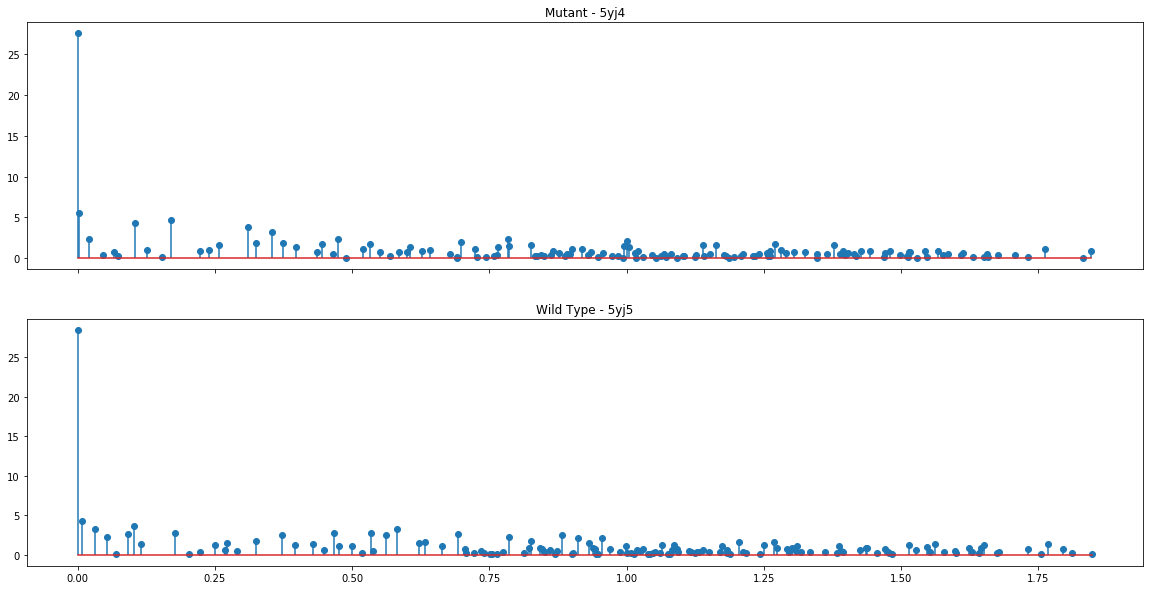

In [94]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(20,10))
ax1.stem(G1.e, np.abs(gftsignal1), use_line_collection=True)
ax1.set_title('Mutant - 5yj4')
ax2.stem(G2.e, np.abs(gftsignal2), use_line_collection=True)
ax2.set_title('Wild Type - 5yj5')

Text(0.5, 1.0, 'Wild Type - 5yj5')

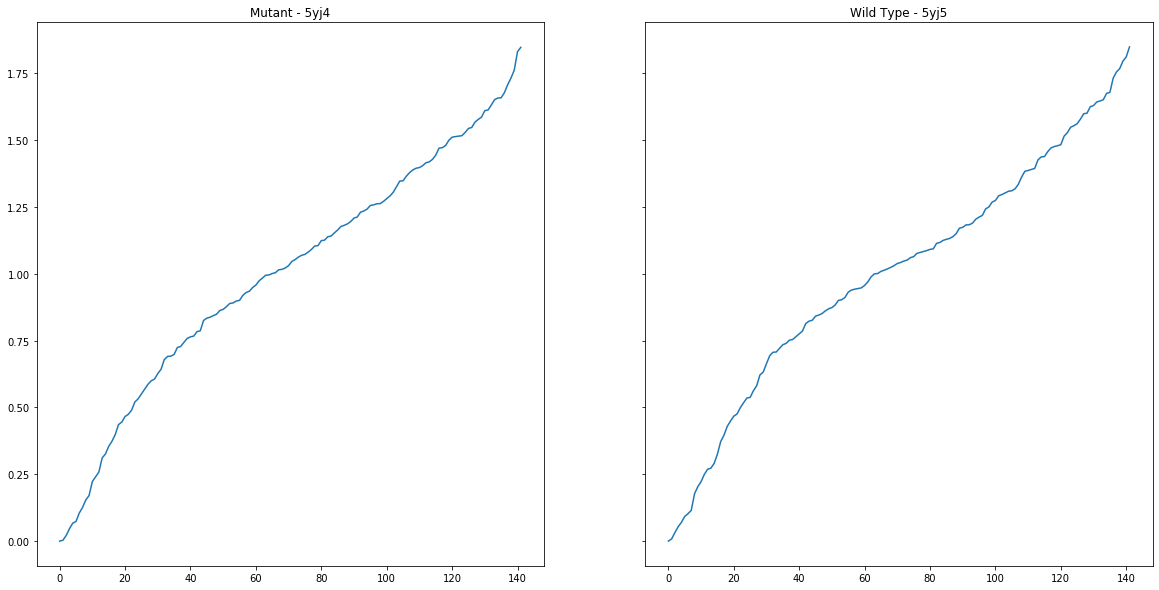

In [95]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(20,10))
ax1.plot(G1.e)
ax1.set_title('Mutant - 5yj4')
ax2.plot(G2.e)
ax2.set_title('Wild Type - 5yj5')

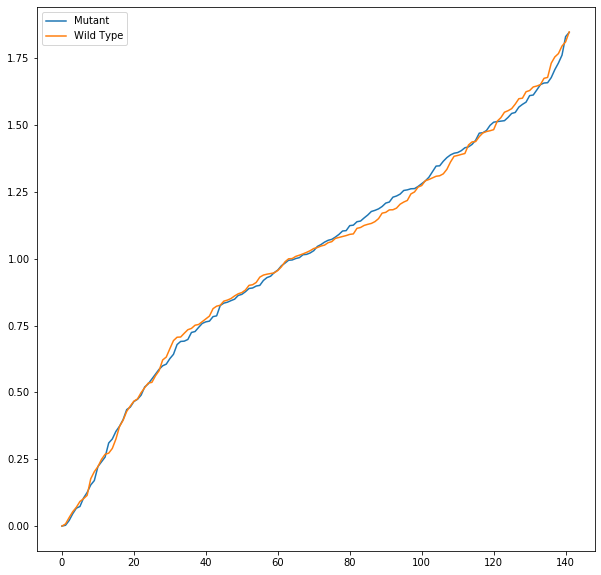

In [100]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(G1.e)
ax.plot(G2.e)
ax.legend(['Mutant', 'Wild Type'])

# Regression model

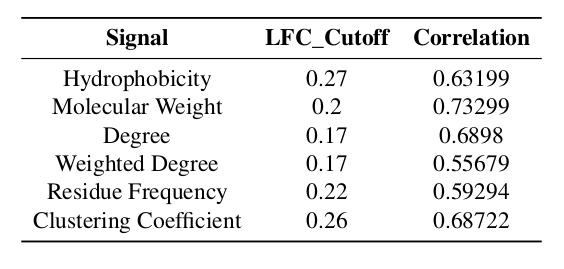

In [48]:
signals_and_cutoffs = {'molecular_weight': 0.2, 
                       'hydrophobicity': 0.27, 
                       'node_degree': 0.17, 
                       'node_weighted_degree': 0.17, 
                       'residue_count': 0.22, 
                       'clustering_coeff': 0.26}

model = 'weighted-rig'
weights = {
    'Intercept': -29.2890, 
    'hydrophobicity': 0.8628, 
    'molecular_weight': 28.5785, 
    'node_degree': 1.4607,
    'node_weighted_degree': 4.8021, 
    'residue_count': -3.6958,
    'clustering_coeff': 11.1305
    }

prediction = weights['Intercept']

for signal_name, lfc_cutoff in signals_and_cutoffs.items():
    G1 = get_graph(pdbinfo_dict['5yj4']['distance_matrix'], network_type=model, rig_cutoff=7.3)
    signal1 = get_signal(G1, pdbinfo_dict['5yj4']['sequence'], signal=signal_name)
    gftsignal1 = G1.gft(signal1)
    signal_hat = gftsignal1
    value = np.sum(abs(signal_hat[G1.e < G1.lmax*lfc_cutoff])) / np.sum(abs(signal_hat))
#     print (signal_name, end=' -- ')
#     print(value)
    prediction += weights[signal_name]*value

print (prediction)
print (np.exp(prediction))

prediction = weights['Intercept']

for signal_name, lfc_cutoff in signals_and_cutoffs.items():
    G2 = get_graph(pdbinfo_dict['5yj5']['distance_matrix'], network_type=model, rig_cutoff=7.2)
    signal2 = get_signal(G2, pdbinfo_dict['5yj5']['sequence'], signal=signal_name)
    gftsignal2 = G2.gft(signal2)
    signal_hat = gftsignal2
    value = np.sum(abs(signal_hat[G2.e < G2.lmax*lfc_cutoff])) / np.sum(abs(signal_hat))
    print (signal_name, end=' -- ')
    print(value)
    prediction += weights[signal_name]*value
    
print (prediction)
print (np.exp(prediction))

-8.579487461540554
0.0001879212696055388
molecular_weight -- 0.4424913685637587
hydrophobicity -- 0.19561848120760447
node_degree -- 0.7574579201459277
node_weighted_degree -- 0.5906514756004387
residue_count -- 0.40653529109415615
clustering_coeff -- 0.4011229604047913
-9.569468581016935
6.982848191854402e-05


142